# Hands-On Naive Bayes
***

In this notebook we'll implement two flavors of continuous Naive Bayes and test it out on the Iris data set.  

**Note**: There are some helper functions at the bottom of this notebook.  Scroll down and execute those cells before continuing. 

In [1]:
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

### Part 1: Classifying Iris Species with Gaussian Naive Bayes 
***

In this problem we'll use K-Nearest Neighbors to classify species of irises based on certain physical characteristics.  The so-called _iris dataset_ is a popular dataset for prototyping classification algorithms. We can load the iris dataset from Scikit-Learn directly. The dataset contains four features: sepal length, sepal width, pedal length, and pedal width and three classes defined by the species of iris: setosa, versicolor, and virginica. We'll only use the sepal dimensions so that we can easily visualize the data. 

Execute the following code cell to load training and validation sets for the iris data set and then plot the data.    

classes =  ['setosa' 'versicolor' 'virginica']


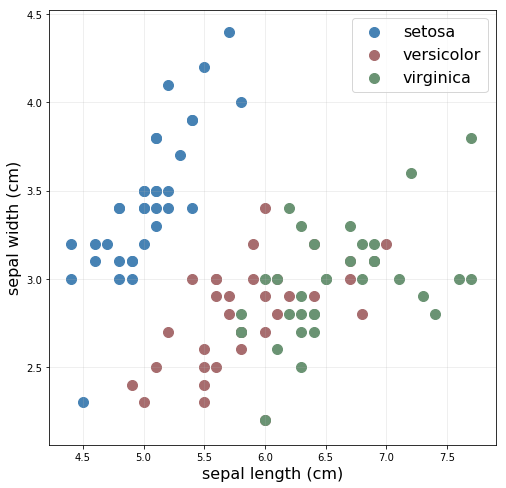

In [3]:
X_train, y_train, X_valid, y_valid, target_names = load_iris()
print("classes = ", target_names)
plot_iris(X_train, y_train)

Our plan in this part is to implement a Gaussian Naive Bayes classifier for this two-feature data. Recall that our goal is to make predictions by computing a class score for a query point of the form 

$$
p(\textrm{Class} \mid {\bf x}) \propto p({\bf x} \mid \textrm{Class}) \cdot p(\textrm{Class}) = p(x_1 \mid \textrm{Class} ) \cdot p(x_2 \mid \textrm{Class}) \cdot p(\textrm{Class})
$$

Note that we assume that feature $x_k$ for data in Class $c$ follows a normal distribution with parameters $\mu_{kc}$ and variance $\sigma_{kc}^2$. If we know these parameters then we can estimate the class conditional likelihood by evaluating the Gaussian probability density function 

$$
p(x_k \mid c) = \frac{1}{\sqrt{2\pi\sigma_{kc}^2}} \textrm{Exp}\left[ -\frac{(x_k - \mu_{kc})^2}{2\sigma_{kc}^2}   \right]
$$

Finally, we can then compute the class-score in **log-space** for each class for a given query point, and then predict it's class membership by predicting the class with the highest score. 

We'll implement this using the class `GaussNB` shown below.  Take a look at the current state of the skeleton, and then scroll down and look at the tasks that we want to accomplish. 

In [23]:
class GaussNB:
    def __init__(self, X_train, y_train):
        
        # store training data 
        self.X_train = X_train
        self.y_train = y_train 
        
        # get number of classes 
        self.num_classes = len(set(y_train))
        
        # initialize means (num_classes x num_features) 
        self.means = np.zeros((self.num_classes, self.X_train.shape[1]))
        
        # initialize variance (num_classes x num_features) 
        self.vars = np.zeros((self.num_classes, self.X_train.shape[1]))
        
        # initialize class counts (num_classes)
        self.counts = np.zeros(self.num_classes)
        
        # initialize class priors (num_classes)
        self.priors = np.zeros(self.num_classes)
        
    def train(self):
        """
        Learn the parameters for the Guassian for each feature-class combination 
        """
        
        # populate the counts array 
        self.counts = np.array([np.sum(y_train == ii) for ii in range(self.num_classes)])
        
        # populate priors 
        self.priors = np.array([self.counts[ii]/np.sum(self.counts) for ii in range(self.num_classes)])
        
        # populate means and variances 
        for feat in range(self.X_train.shape[1]):
            for c in range(self.num_classes):
                self.means[c, feat] = np.mean(self.X_train[self.y_train==c, feat])
                self.vars[c, feat] = np.var(self.X_train[self.y_train==c, feat])
                
    def pdf(self, xk, mu, ssq):
        """
        evaluates the Gaussian probability density function 
        """
        return np.exp(-((xk-mu)**2)/(2*ssq)) / np.sqrt(2*np.pi*ssq)
        
    def predict_log_score(self, x):
        """
        Get the log-probability score for each class
        for a query point x 
        """
        
        class_scores = np.zeros(self.num_classes) 
        
        for c in range(self.num_classes):
            class_scores[c] = np.log(self.priors[c])
            for kk in range(len(x)):
                class_scores[c] += np.log(self.pdf(x[kk], self.means[c, kk], self.vars[c,kk]))
        
        return class_scores
    
    def predict(self, X):
        """
        Predict the class of each example in X 
        """
        yhat = np.zeros(X.shape[0], dtype=int)
        for ii, x in enumerate(X):
            class_scores = self.predict_log_score(x)
            yhat[ii] = np.argmax(class_scores)
        
        return yhat 
    
    def accuracy(self, X, y):
        yhat = self.predict(X)
        return np.sum(yhat == y)/len(y)
        
        

**Part A**: The first thing we'll do is fill in the `train` function.  We start by filling in the array corresponding to the prior for each class.  To necessitate this we'll first fill in the counts of the training examples for each class. When you're done, execute the following code cell.  Do the results mesh with what we know about the Iris dataset. 

In [24]:
gnb = GaussNB(X_train, y_train)
gnb.train()
print("class counts: ", gnb.counts)
print("class priors: ", gnb.priors)

class counts:  [34 34 34]
class priors:  [ 0.33333333  0.33333333  0.33333333]


**Part B**: Next we need to learn the parameters of the Gaussian distributions for each feature and each class from the training data.  Note that we'll store the means and the variances in separate matrices of dimensions `num_classes` $\times$ `num_features`.  Add this functionality to the `train` function.  When you think you're done, execute the following cell.  Do the values seem correct given the plot of the Iris data set we made above? 

In [25]:
gnb = GaussNB(X_train, y_train)
gnb.train()
print("means:\n ", gnb.means)
print("\nvars:\n ", gnb.vars)

means:
  [[ 5.02352941  3.43823529]
 [ 5.87941176  2.8       ]
 [ 6.58235294  2.97058824]]

vars:
  [[ 0.1082699   0.16530277]
 [ 0.27339965  0.08470588]
 [ 0.28262976  0.09207612]]


**Part C**: OK, now let's implement functionality to make predictions.  Note that there are two related functions called `predict` and `predict_log_score`.  We'll be working on the latter of those two. Our goal is to compute the log-score for each class for a particular query point: 

$$
\textrm{class_score}[c] = \log~p(c) + \log~p(x_1 \mid c) + \log~p(x_2 \mid c)
$$

For our data this should return a numpy array of length $3$. The `predict` function is implemented for you.  It loops over a data matrix of features, calls `predict_log_score` on each example, and then predicts the class corresponding to the higher log-score.  

Fill out the missing code in `predict_log_score`, and then run the following code cell. If your code is working then you should predict that the first query point belongs to class 0, the second to class 1, and the third to class 2.   

In [26]:
gnb = GaussNB(X_train, y_train)
gnb.train()
X_test = np.array([[4.5, 4.0], [5.5, 2.5], [8,3]])
gnb.predict(X_test)

array([0, 1, 2])

**Part D**: When it seems like your code is working, you can run the following code cell to plot the class decision boundaries induced by this classifier.  

accuracy: 0.80


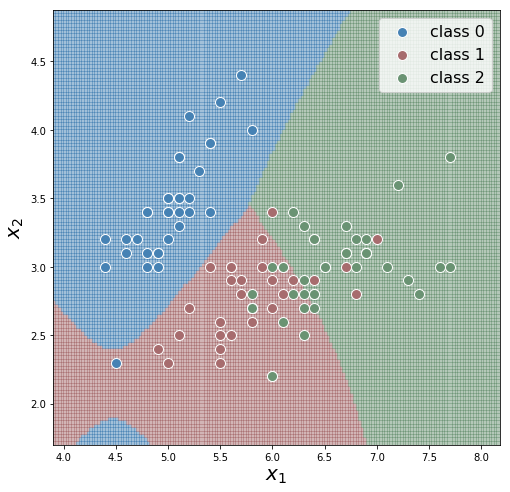

In [27]:
gnb = GaussNB(X_train, y_train)
gnb.train()
print("accuracy: {:.2f}".format(gnb.accuracy(X_train, y_train)))
nb_plot(X_train, y_train, gnb, db=True)

**Part E**: OK, let's take a step back and look at the kinds of decision boundaries Gaussian Naive Bayes can learn for binary data. The following code lets you generate binary labeled data with two features in different configurations.  Experiment with different configurations and discuss the types of decision boundaries that you can and CAN'T learn.      

In [28]:
yb_train.shape

(200,)

In [29]:
gnb2.num_classes

2

accuracy = 0.50


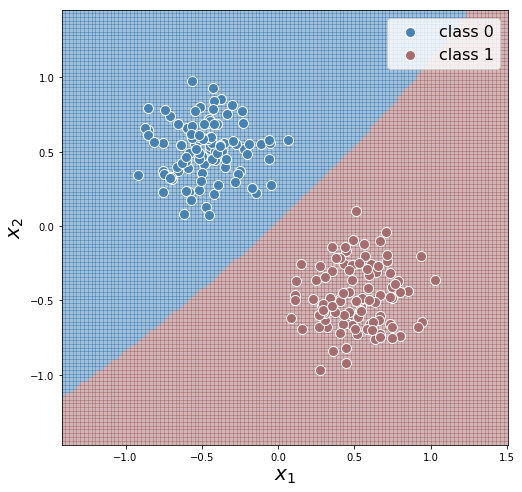

In [30]:
Xb_train, yb_train = generate_data(200, config="blobs")
gnb2 = GaussNB(Xb_train, yb_train)
gnb2.train()
nb_plot(Xb_train, yb_train, gnb2, db=True)
print("accuracy = {:.2f}".format(gnb.accuracy(Xb_train, yb_train)))

### Part 2: Classifying Iris Species with Discretized Naive Bayes 
***

Next we'll try to build a Naive Bayes classifier by discretizing the continuous features into bins and then performing Discrete Naive Bayes.  How should we modify our class data structures to accomplish this?    


In [31]:
class DiscretizedNB:
    def __init__(self, X_train, y_train, percents=[25, 50, 75]):
        
        # store training data 
        self.X_train = X_train
        self.y_train = y_train 
        
        # store percentile boundaries
        self.percents = percents
        
        # get number of bins
        self.num_bins = len(self.percents) + 1 
        
        # get number of classes 
        self.num_classes = len(set(y_train))
        
        # initialize class counts (num_classes)
        self.counts = np.zeros(self.num_classes)
        
        # initialize class priors (num_classes)
        self.priors = np.zeros(self.num_classes)
        
        # initialize percentiles (num_percentiles x num_features) 
        self.percentiles = np.zeros((len(self.percents), self.X_train.shape[1]))
        
        # initalize class likelihoods for binarized features ()
        self.classlike = np.ones((self.num_classes, self.X_train.shape[1], self.num_bins))
        
    def train(self):
        """
        Learn the parameters for the Guassian for each feature-class combination 
        """
        
        # populate the counts array 
        self.counts = np.array([np.sum(y_train == c) for c in range(self.num_classes)])
        
        # populate priors 
        self.priors = np.array([self.counts[ii]/np.sum(self.counts) for ii in range(self.num_classes)])
        
        # populate percentiles
        for feat in range(self.X_train.shape[1]):
            self.percentiles[:,feat] = np.percentile(self.X_train[:,feat], self.percents)
        
        # populate class-conditional likelihoods 
        for c in range(self.num_classes):
            for x in self.X_train[self.y_train == c]: 
                for feat in range(self.X_train.shape[1]):
                    self.classlike[c][feat][np.sum(x[feat] > self.percentiles[:,feat])] += 1 
                    
        # normalize by number of things in each class + 4 for Laplace smoothing
        for c in range(self.num_classes):
            self.classlike[c] /= (self.counts[c] + self.num_bins) 
                
    def predict_log_score(self, x):
        """
        Get the log-probability score for each class
        for a query point x 
        """
        
        class_scores = np.zeros(self.num_classes) 
        
        for c in range(self.num_classes):
            class_scores[c] = np.log(self.priors[c])
            for feat in range(len(x)):
                class_scores[c] += np.log(self.classlike[c][feat][np.sum(x[feat] > self.percentiles[:,feat])])
        
        return class_scores
    
    def predict(self, X):
        """
        Predict the class of each example in X 
        """
        yhat = np.zeros(X.shape[0], dtype=int)
        for ii, x in enumerate(X):
            class_scores = self.predict_log_score(x)
            yhat[ii] = np.argmax(class_scores)
        
        return yhat 
    
    def accuracy(self, X, y):
        yhat = self.predict(X)
        return np.sum(yhat == y)/len(y)
        
        

accuracy: 0.83


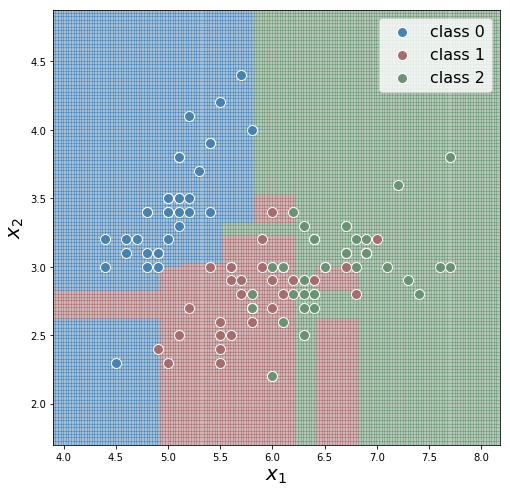

In [32]:
gnb = DiscretizedNB(X_train, y_train, percents=[12.5, 25, 37.5, 50, 67.5, 75, 87.5])
gnb.train()
print("accuracy: {:.2f}".format(gnb.accuracy(X_train, y_train)))
nb_plot(X_train, y_train, gnb, db=True)

accuracy = 1.00


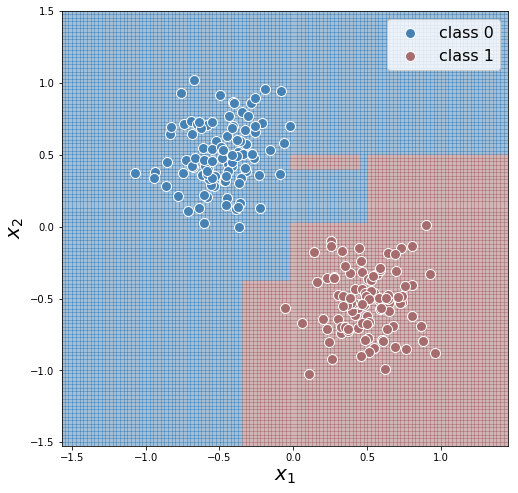

In [33]:
Xb_train, yb_train = generate_data(200, config="blobs")
gnb = DiscretizedNB(Xb_train, yb_train, percents=[12.5, 25, 37.5, 50, 67.5, 75, 87.5])
gnb.train()
nb_plot(Xb_train, yb_train, gnb, db=True)
print("accuracy = {:.2f}".format(gnb.accuracy(Xb_train, yb_train)))

<br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br>

### Helper Functions
***

In [34]:
def load_iris(standardize=False, random_state=1234): 
    
    from sklearn import datasets
    from sklearn.preprocessing import StandardScaler 
    
    np.random.seed(random_state)

def load_iris(standardize=False, random_state=1234): 
    
    from sklearn import datasets
    from sklearn.preprocessing import StandardScaler 
    
    np.random.seed(random_state)
    
    # Load the data and grab first two features 
    iris = datasets.load_iris()
    X, y = iris.data[:,:2], iris.target 
    
    # Split by species 
    S = {}
    for k in [0,1,2]:
        S[k] = X[y==k]
        
    # Randomly split into validation and training sets 
    ones = np.ones(50, dtype=int)
    valid_mask = np.full(50, False)
    valid_mask[np.random.choice(range(50), replace=False, size=16)] = True 
    train_mask = np.logical_not(valid_mask)
    X_train = np.concatenate((X[y==0][train_mask], X[y==1][train_mask], X[y==2][train_mask]))
    y_train = np.concatenate((0*ones[train_mask], 1*ones[train_mask], 2*ones[train_mask]))
    X_valid = np.concatenate((X[y==0][valid_mask], X[y==1][valid_mask], X[y==2][valid_mask]))
    y_valid = np.concatenate((0*ones[valid_mask], 1*ones[valid_mask], 2*ones[valid_mask]))
    
    # Standardize data if desired 
    if standardize: 
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        
    return X_train, y_train, X_valid, y_valid, iris.target_names
    

def plot_iris(X, y):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    name_color_dict = {0: ("steelblue", "setosa"), 1:("#a76c6e", "versicolor"), 2:("#6a9373", "virginica")}
    for k in [0,1,2]:
        ax.scatter(X[y==k,0], X[y==k,1], color=name_color_dict[k][0], s=100, label=name_color_dict[k][1])
    ax.grid(alpha=0.25)
    ax.legend(loc="upper right", fontsize=16)
    ax.set_xlabel("sepal length (cm)", fontsize=16)
    ax.set_ylabel("sepal width (cm)", fontsize=16)
    
def nb_plot(X, y, model, db=True):
    
    from matplotlib import colors
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    
    name_color_dict = {0: ("steelblue", "setosa"), 1:('#a76c6e', "versicolor"), 2:('#6a9373', "virginica")}
    for k in list(set(y)):
        ax.scatter(X[y==k,0], X[y==k,1], color=name_color_dict[k][0], s=100, label="class " + str(k), edgecolors="white", zorder=2)
        
    # Plot the decision boundary. 
    if db:
        x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
        y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.025), np.arange(y_min, y_max, 0.025))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

        # Define custom colormap 
        cmap = colors.ListedColormap(['steelblue', '#a76c6e', '#6a9373'][:max(y)+1])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap, alpha=0.5, zorder=1)

    ax.legend(loc="upper right", fontsize=16)
    ax.set_xlabel(r"$x_1$", fontsize=20)
    ax.set_ylabel(r"$x_2$", fontsize=20) 
    
def generate_data(N, config="checkerboard"):
    
    from sklearn import datasets
    
    X = np.zeros((N,2))
    y = np.zeros(N).astype(int)
    
    if config=="checkerboard":
        nps, sqlen = N//9, 2/3
        ctr = 0
        for ii in range(3):
            for jj in range(3):
                X[ctr*nps:(ctr+1)*nps,:] = np.column_stack(
                    (np.random.uniform(ii*sqlen+.05-1,(ii+1)*sqlen-.05-1,size=nps),
                     np.random.uniform(jj*sqlen+.05-1,(jj+1)*sqlen-.05-1,size=nps))) 
                y[ctr*nps:(ctr+1)*nps] = (3*ii+jj)%2
                ctr += 1
                
    if config=="blobs":            
        
        X, y = datasets.make_blobs(n_samples=N, centers=[[-.5,.5],[.5,-.5]], cluster_std=[.20,.20],n_features=2)
        
    if config=="circles":
        kk=0
        while kk < N/2:
            sample = 2*np.random.rand(2)-1 
            if np.linalg.norm(sample) <= .45:
                X[kk,:] = sample 
                y[kk] = 0
                kk += 1 
        while kk < N:
            sample = 2*np.random.rand(2)-1 
            dist = np.linalg.norm(sample)
            if dist < 0.9 and dist > 0.55:
                X[kk,:] = sample 
                y[kk] = 1
                kk += 1
                
    if config=="moons":
        X, y = datasets.make_moons(n_samples=N, noise=.05)
        X[:,0] = .5*(X[:,0]-.5)
        X[:,1] = X[:,1]-.25
            
    return X, y